In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run
import multiprocessing

from scipy.stats import ttest_ind
from scipy.stats import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import kruskal
import scikit_posthocs as sp

# Curve for preference of similar neighbours

In [4]:
def get_theta(x, mu, sigma):
    """
    x: fraction of similar neighbours
    mu: optimal fraction of similar neighbours
    sigma: acceptance range
    """
    theta = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return theta

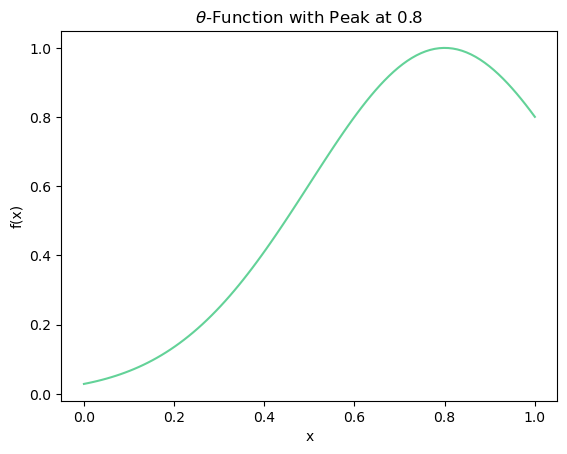

In [5]:
def gaussian_function(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Example usage:
x_values = np.linspace(0, 1, 100)
mu = 0.8  # Controls the peak location
sigma = 0.3  # Controls the width

y_values = gaussian_function(x_values, mu, sigma)

plt.plot(x_values, y_values, color = '#63d298ff')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'$\theta$-Function with Peak at 0.8')
plt.show()

# Experiment

In [6]:
from model import Schelling
from modules import property_value_from_gdf, update_interested_agents_concurrently, property_value_func_random, utility_func, price_func, income_func, property_value_from_gdf, property_value_quadrants, desirability_func, compute_similar_neighbours, property_value_equal, calculate_gi_star, price_func_cap

# Function for simulation using the Singapore policy
def schelling_singapore(num_runs, num_steps, burn_in_period, minority_pc, property_value_weight, alpha, mu_theta, sigma_theta, density, policy = True):

    # initialize storage for parameters
    overall_desirability_entropy = []
    overall_agent_entropy = []
    overall_utility = []

    # run the model several times for the same parameter setting 
    for run in range(num_runs):
        print('I am in round', run)
        
        # initialize model
        models = Schelling(
            property_value_func=property_value_from_gdf, # quadrants,
            income_func=income_func,
            desirability_func=desirability_func,
            utility_func=utility_func,
            price_func=price_func,
            compute_similar_neighbours=compute_similar_neighbours,
            calculate_gi_star = calculate_gi_star,
            update_interested_agents_func = update_interested_agents_concurrently,
            price_func_cap=price_func_cap,
            policy_singapore=policy,
            #height=20,
            #width=20,
            radius=1,
            density=density,
            minority_pc=minority_pc,
            alpha=alpha,
            income_scale=1.5, # the scale by which the income is higher than the property value
            property_value_weight=property_value_weight,
            mu_theta = mu_theta,
            sigma_theta = sigma_theta,
            seed=41)

        # Run the model for a certain number of steps
        for _ in range(num_steps):
            models.step()

        # call necessary data collectors
        agent_data = models.datacollector.get_agent_vars_dataframe()
        model_data_entropy = models.datacollector.get_model_vars_dataframe()
    
        # Compute mean and standard deviation of entropies over time per run
        desirability_entropy = model_data_entropy['Desirability entropy'].to_numpy()
        mean_desirability_entropy = np.mean(np.array(desirability_entropy[burn_in_period::]))
        
        agent_entropy = model_data_entropy['Agent entropy'].to_numpy()
        mean_agent_entropy = np.mean(np.array(agent_entropy[burn_in_period::]))
        # print(agent_entropy)
        
        # Compute mean and standard deviation of utility per time step over each agent 
        utility_mean = agent_data.groupby(level='Step')['Utility'].mean()
        utility_std = agent_data.groupby(level='Step')['Utility'].std()
        
        # Compute mean and standard deviation of utility over time 
        utility_mean = pd.DataFrame(utility_mean).to_numpy()
        utility_std = pd.DataFrame(utility_std).to_numpy()
        mean_utility_interim = np.mean(utility_mean[burn_in_period::])

        # Append all results to storage
        overall_desirability_entropy.append(mean_desirability_entropy)
        overall_agent_entropy.append(mean_agent_entropy)
        overall_utility.append(mean_utility_interim)

    return np.array(overall_desirability_entropy), np.array(overall_agent_entropy), np.array(overall_utility)

# Singapore experiment

In [7]:
# experiment settings
num_iters = 100
burn_in_period = 5
model_steps = 30

# model settings
density = 0.8
minority = 0.3
alpha = 0.5
property_value_weight = 0.1
mu = 0.8
sigma = 0.3

# Run simulation
singapore_policy_effect = schelling_singapore(num_iters, model_steps, burn_in_period, minority, property_value_weight, alpha, mu, sigma, density)

Skipping field color: unsupported OGR type: 3


I am in round 0


Skipping field color: unsupported OGR type: 3


I am in round 1


Skipping field color: unsupported OGR type: 3


I am in round 2


KeyboardInterrupt: 

In [8]:
# Save simulation 
singapore_initial_results = np.column_stack((singapore_policy_effect[0], singapore_policy_effect[1], singapore_policy_effect[2]))

# Save the stacked array to a CSV file
#np.savetxt('singapore_policy_100_runs_2.csv', singapore_initial_results, delimiter=',', header='desirability_entropy, agent_entropy, utility') 

NameError: name 'singapore_policy_effect' is not defined

# No policy experiment

In [9]:
# experiment settings
num_iters = 100
burn_in_period = 5
model_steps = 30

# model settings
density = 0.8
minority = 0.3
alpha = 0.5
property_value_weight = 0.1
mu = 0.8
sigma = 0.3

# Run simulation
no_policy_effect = schelling_singapore(num_iters, model_steps, burn_in_period, density, minority, alpha, property_value_weight, mu, sigma, policy=False)

Skipping field color: unsupported OGR type: 3


I am in round 0


KeyboardInterrupt: 

In [10]:
no_policy_results = np.column_stack((no_policy_effect[0], no_policy_effect[1], no_policy_effect[2]))

# Save the stacked array to a CSV file
#np.savetxt('no_policy_result_100_runs.csv', no_policy_results, delimiter=',', header='desirability_entropy, agent_entropy, utility') 

NameError: name 'no_policy_effect' is not defined

# Vienna experiment

In [11]:
import modules as modules
import model as model
from model import Schelling

# Define function for simulation
def schelling_vienna(num_runs, num_steps, burn_in_period, minority_pc, property_value_weight, alpha, mu_theta, sigma_theta, density, policy = True):

    # initialize storage for parameters
    overall_desirability_entropy = []
    overall_agent_entropy = []
    overall_utility = []

    # run the model several times for the same parameter setting 
    for run in range(num_runs):
        print('I am in round', run)
        
        # initialize model
        models = Schelling(
            property_value_func=modules.property_value_from_gdf, # quadrants,
            income_func=modules.income_func,
            desirability_func=modules.desirability_func,
            utility_func=modules.utility_func,
            price_func=modules.price_func,
            compute_similar_neighbours=modules.compute_similar_neighbours,
            calculate_gi_star = modules.calculate_gi_star,
            update_interested_agents_func = modules.update_interested_agents_concurrently,
            price_func_cap=modules.price_func_cap,
            policy_vienna=policy,
            #height=20,
            #width=20,
            radius=1,
            density=density,
            minority_pc=minority_pc,
            alpha=alpha,
            income_scale=1.5, # the scale by which the income is higher than the property value
            property_value_weight=property_value_weight,
            mu_theta = mu_theta,
            sigma_theta = sigma_theta,
            seed=42)

        # Run the model for a certain number of steps
        for _ in range(num_steps):
            models.step()

        # call necessary data collectors
        agent_data = models.datacollector.get_agent_vars_dataframe()
        model_data_entropy = models.datacollector.get_model_vars_dataframe()
    
        # Compute mean and standard deviation of entropies over time per run
        desirability_entropy = model_data_entropy['Desirability entropy'].to_numpy()
        mean_desirability_entropy = np.mean(np.array(desirability_entropy[burn_in_period::]))
        
        agent_entropy = model_data_entropy['Agent entropy'].to_numpy()
        mean_agent_entropy = np.mean(np.array(agent_entropy[burn_in_period::]))
        #print(agent_entropy)
        
        # Compute mean and standard deviation of utility per time step over each agent 
        utility_mean = agent_data.groupby(level='Step')['Utility'].mean()
        utility_std = agent_data.groupby(level='Step')['Utility'].std()
        
        # Compute mean and standard deviation of utility over time 
        utility_mean = pd.DataFrame(utility_mean).to_numpy()
        utility_std = pd.DataFrame(utility_std).to_numpy()
        mean_utility_interim = np.mean(utility_mean[burn_in_period::])

        # Append all results to storage
        overall_desirability_entropy.append(mean_desirability_entropy)
        overall_agent_entropy.append(mean_agent_entropy)
        overall_utility.append(mean_utility_interim)

    return np.array(overall_desirability_entropy), np.array(overall_agent_entropy), np.array(overall_utility)

In [12]:
# experiment settings
num_iters = 100
burn_in_period = 5
model_steps = 30

# model settings
density = 0.8
minority = 0.3
alpha = 0.5
property_value_weight = 0.1
mu = 0.8
sigma = 0.3

# Run simulation
vienna_policy_effect = schelling_vienna(num_iters, model_steps, burn_in_period, density, minority, alpha, property_value_weight, mu, sigma, policy=True)

Skipping field color: unsupported OGR type: 3


I am in round 0


KeyboardInterrupt: 

In [13]:
vienna_policy_effect = np.column_stack((vienna_policy_effect[0], vienna_policy_effect[1], vienna_policy_effect[2]))

# Save the stacked array to a CSV file
#np.savetxt('vienna_policy_result_100_runs2.csv', vienna_policy_effect, delimiter=',', header='desirability_entropy, agent_entropy, utility') 

NameError: name 'vienna_policy_effect' is not defined

# Plots for initial experiment 

In [14]:
# Load data again (in case not newly generated)
singapore_results = pd.read_csv('singapore_policy_100_runs_2.csv')
vienna_results = pd.read_csv('vienna_policy_result_100_runs2.csv')
random_results = pd.read_csv('no_policy_result_100_runs.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'singapore_policy_100_runs_2.csv'

In [15]:
desirability_vienna = vienna_results['# desirability_entropy'].to_numpy()
desirability_singapore = singapore_results['# desirability_entropy'].to_numpy()
desirability_random = random_results['# desirability_entropy'].to_numpy()

agent_vienna = vienna_results[' agent_entropy'].to_numpy()
agent_singapore = singapore_results[' agent_entropy'].to_numpy()
agent_random = random_results[' agent_entropy'].to_numpy()

utility_vienna = vienna_results[' utility'].to_numpy()
utility_singapore = singapore_results[' utility'].to_numpy()
utility_random = random_results[' utility'].to_numpy()

plt.figure(dpi = 300, figsize = (10, 16))

plt.subplot(311)
# Create distribution plots for both datasets
sns.histplot(desirability_vienna, kde=True, color='#63d298ff', label='Policy: Vienna', stat="density")
sns.histplot(desirability_singapore, kde=True, color='#fff176ff', label='Policy: Singapore', stat="density")
sns.histplot(desirability_random, kde=True, color='#ff5252ff', label='no policy', stat="density")

# Customize the plot
plt.title('Desirability: Distribution Plots of different Policies')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.subplot(312)
# Create distribution plots for both datasets
sns.histplot(agent_vienna, kde=True, color='#63d298ff', label='Policy: Vienna', stat="density")
sns.histplot(agent_singapore, kde=True, color='#fff176ff', label='Policy: Singapore', stat="density")
sns.histplot(agent_random, kde=True, color='#ff5252ff', label='no policy', stat="density")

# Customize the plot
plt.title('Agent entropy: Distribution Plots of different Policies')
plt.xlabel('Value')
plt.ylabel('Density')

plt.subplot(313)
# Create distribution plots for both datasets
sns.histplot(utility_vienna, kde=True, color='#63d298ff', label='Policy: Vienna', stat="density")
sns.histplot(utility_singapore, kde=True, color='#fff176ff', label='Policy: Singapore', stat="density")
sns.histplot(utility_random, kde=True, color='#ff5252ff', label='no policy', stat="density")

# Customize the plot
plt.title('Average utility: Distribution Plots of different Policies')
plt.xlabel('Value')
plt.ylabel('Density')

# Show the plot
plt.savefig('Experiment_Results')
plt.show()
plt.close()

NameError: name 'vienna_results' is not defined

# Local Sensitivity analysis; Varying Density 

## Functions:

In [16]:
def run_sensitivity_analysis(model_class, fixed_params, variable_params, iterations, max_steps, data_collection_period, features_to_analyze, steps_to_skip=5):
    # Perform the batch run with the specified parameters
    results = batch_run(
        model_class,
        parameters={**fixed_params, **variable_params},
        iterations=iterations,
        max_steps=max_steps,
        number_processes=None,
        data_collection_period=data_collection_period,
        display_progress=True
    )
    
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)
    
    # Filter out the initial steps to skip
    filtered_results = results_df[results_df['Step'] > steps_to_skip]
    
    # Prepare a dictionary to store the mean and std of the specified features
    analysis_results = {}
    
    # Analyze each feature specified
    for feature in features_to_analyze:
        mean_feature = filtered_results.groupby(list(variable_params.keys()))[feature].mean().reset_index()
        std_feature = filtered_results.groupby(list(variable_params.keys()))[feature].std().reset_index()
        analysis_results[feature] = {
            'mean': mean_feature,
            'std': std_feature
        }
    
    return analysis_results

In [17]:
def plot_feature_analysis(feature_analysis, feature_name, variable_param_name):
    mean_df = feature_analysis[feature_name]['mean']
    std_df = feature_analysis[feature_name]['std']
    
    plt.figure(figsize=(10, 6), dpi=300)
    
    # Plot the mean with standard deviation as error bars
    plt.errorbar(mean_df[variable_param_name], mean_df[feature_name], 
                 yerr=std_df[feature_name], fmt='o', capsize=5, 
                 label=f'Average {feature_name}', color='#63d298ff')
    
    plt.title(f'Average {feature_name} vs {variable_param_name} with Standard Deviation')
    plt.xlabel(variable_param_name)
    #plt.ylim(0,1)
    plt.ylabel(feature_name)
    plt.legend()
    plt.grid(True)
    plt.savefig('diff_singapore_param_entropy_desirable.png')
    plt.show()

In [18]:
def plot_feature_analysis_multiple(feature_analyses, feature_name, variable_param_name, labels=None):
    """
    Plots the specified feature from multiple analyses on the same plot with different colors.
    
    Parameters:
    feature_analyses (list of dict): List of feature analysis dictionaries containing 'mean' and 'std' data frames.
    feature_name (str): Name of the feature to plot.
    variable_param_name (str): Name of the variable parameter to plot on the X-axis.
    labels (list of str): List of labels for the analyses. Defaults to None.
    """
    
    plt.figure(figsize=(10, 6), dpi=300)
    colors = ['#63d298ff', '#ff5252ff', '#fff176ff'] # plt.cm.rainbow(np.linspace(0, 1, len(feature_analyses)))
    
    for i, feature_analysis in enumerate(feature_analyses):
        mean_df = feature_analysis[feature_name]['mean']
        std_df = feature_analysis[feature_name]['std']
        label = labels[i] if labels else f"Analysis {i+1}"
        
        # Plot the mean with standard deviation as error bars
        plt.errorbar(mean_df[variable_param_name], mean_df[feature_name], 
                     yerr=std_df[feature_name], fmt='o', capsize=5, 
                     label=label, color=colors[i])
    
    plt.title(f'Average {feature_name} over {variable_param_name}')
    plt.xlabel(variable_param_name)
    plt.ylabel(feature_name)
    plt.legend()
    plt.grid(True)
    #plt.savefig('avarage_desirable_entropy_sigma_diff_policy.png')
    plt.show()

# Example usage:
# Assuming `feature_analyses` is a list of dictionaries with the required structure
# feature_analyses = [analysis1, analysis2, analysis3]
# plot_feature_analysis_multiple(feature_analyses, 'feature_name', 'variable_param_name', labels=['Analysis 1', 'Analysis 2', 'Analysis 3'])

## Example usage:

In [19]:
iterations = 100
max_steps = 30

# Example usage:
fixed_params = {
    "property_value_func": modules.property_value_from_gdf,
    "income_func": modules.income_func,
    "desirability_func": modules.desirability_func,
    "update_interested_agents_func": modules.update_interested_agents_concurrently,
    "utility_func": modules.utility_func,
    "price_func": modules.price_func,
    "compute_similar_neighbours": modules.compute_similar_neighbours,
    "calculate_gi_star": modules.calculate_gi_star,
    "price_func_cap": modules.price_func_cap,
    "height": 20,
    "width": 20,
    "policy_singapore_threshold": 0.8,
    "density": 0.8,
    "minority_pc": 0.2,
    "alpha": 0.5,
    "income_scale": 1.5,
    "property_value_weight": 0.35,
    "mu_theta": 0.8,
    "sigma_theta": 0.3
}

variable_params = {
    'density': np.linspace(0, 1, 10),
}

features_to_analyze = ["Utility", "Agent entropy", "Desirability entropy"]


In [20]:
# Run the sensitivity analysis
analysis_density_no_policy = run_sensitivity_analysis(
    model_class=model.Schelling,
    fixed_params=fixed_params,
    variable_params=variable_params,
    iterations=iterations,
    max_steps=max_steps,
    data_collection_period=8,
    features_to_analyze=features_to_analyze
)


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/jennadevries/Desktop/FINAL_CODE/modules.py:67: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/jennadevries/Desktop/FINAL_CODE/modules.py:67: FutureWarning: The new PropertyLayer and _PropertyGrid classes experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1932
  layer = mesa.space.PropertyLayer(name, width, height, 0)
Skipping field color: unsupported OGR type: 3
/Users/jennadevries/Desktop/FINAL_CODE/modules.py:67: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/jennadevries/Desktop/FINAL_CODE/modules.py:67: FutureWarning: The new PropertyLayer and _PropertyGrid classes exper

KeyboardInterrupt: 

In [21]:
plot_feature_analysis(analysis_density_no_policy, "Agent entropy", "density")
plot_feature_analysis(analysis_density_no_policy,"Desirability entropy", "density")
plot_feature_analysis(analysis_density_no_policy, "Utility", "density")

NameError: name 'analysis_density_no_policy' is not defined

# Statistical testing of results

In [23]:
# Load the data from CSV files
data_vienna_policy = pd.read_csv("vienna_policy_result_100_runs2.csv")
data_singapore_policy = pd.read_csv("singapore_policy_100_runs_2.csv")
data_no_policy = pd.read_csv("no_policy_result_100_runs.csv")

data_vienna_policy.columns = data_vienna_policy.columns.str.strip()
data_no_policy.columns = data_no_policy.columns.str.strip()
data_singapore_policy.columns = data_singapore_policy.columns.str.strip()

# Metrics to compare
metrics = ["# desirability_entropy", "agent_entropy", "utility"]

In [ ]:
# Prepare data for ANOVA
data_combined = pd.concat([data_vienna_policy.assign(policy='Vienna'),
                           data_singapore_policy.assign(policy='Singapore'),
                           data_no_policy.assign(policy='No Policy')])


: 

In [ ]:
# Fit the ANOVA model for each metric
metrics = ["desirability_entropy", "agent_entropy", "utility"]
anova_results = {}

for metric in metrics:
    model = smf.ols(f'{metric} ~ C(policy)', data=data_combined).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results[metric] = anova_table
    print(f'ANOVA result for {metric}:')
    print(anova_table)
    print('\n')

    # Check normality of residuals
    residuals = model.resid
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sm.qqplot(residuals, line='s', ax=ax[0])
    ax[0].set_title('Q-Q Plot')
    
    sns.histplot(residuals, kde=True, ax=ax[1])
    ax[1].set_title('Histogram of Residuals')
    plt.show()

    # Shapiro-Wilk test
    shapiro_test = stats.shapiro(residuals)
    print('Shapiro-Wilk Test:')
    print('Statistic:', shapiro_test.statistic)
    print('p-value:', shapiro_test.pvalue)
    print('\n')

    # Check homogeneity of variances
    # Levene's Test
    levene_test = stats.levene(
        data_combined[data_combined['policy'] == 'Vienna'][metric],
        data_combined[data_combined['policy'] == 'Singapore'][metric],
        data_combined[data_combined['policy'] == 'No Policy'][metric]
    )
    print('Levene\'s Test:')
    print('Statistic:', levene_test.statistic)
    print('p-value:', levene_test.pvalue)
    print('\n')

    # Plot residuals vs. fitted values
    fitted_vals = model.fittedvalues
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(x=fitted_vals, y=residuals, ax=ax)
    ax.axhline(0, linestyle='--', color='r')
    ax.set_xlabel('Fitted Values')
    ax.set_ylabel('Residuals')
    ax.set_title('Residuals vs. Fitted Values')
    plt.show()

    # Check independence of observations
    # Durbin-Watson test
    durbin_watson_test = sm.stats.durbin_watson(residuals)
    print('Durbin-Watson Test:')
    print('Statistic:', durbin_watson_test)
    print('\n')

# Variance Inflation Factor (VIF) to check for multicollinearity (if applicable)
variables = model.model.exog
vif_data = pd.DataFrame()
vif_data['VIF'] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif_data['variable'] = model.model.exog_names
print(vif_data)

: 

# Perform Kruskall Wallis for when assumptions are not met; desirability and utility

In [ ]:
#Extract groups
groups = [data_combined[data_combined['policy'] == policy]['utility'].values for policy in data_combined['policy'].unique()]

# Perform Kruskal-Wallis Test
statistic, p_value = kruskal(*groups)

print(f"Kruskal-Wallis H test statistic: {statistic}")
print(f"p-value: {p_value}")

: 

In [ ]:
groups = [data_combined[data_combined['policy'] == policy]['desirability_entropy'].values for policy in data_combined['policy'].unique()]
# Perform Kruskal-Wallis Test
statistic, p_value = kruskal(*groups)

print(f"Kruskal-Wallis H test statistic: {statistic}")
print(f"p-value: {p_value}")

: 

# singificant p-value indicates differences between groups, so post hoc analysis 
One commonly used post-hoc test for non-parametric data is the Dunn’s test with a Bonferroni correction for multiple comparisons.

In [ ]:
# Perform Dunn's test
dunn_results = sp.posthoc_dunn(data_combined, val_col='utility', group_col='policy', p_adjust='bonferroni')

print(dunn_results)

: 

In [ ]:
dunn_results = sp.posthoc_dunn(data_combined, val_col='desirability_entropy', group_col='policy', p_adjust='bonferroni')

print(dunn_results)

: 

In [ ]:
# Fit the ANOVA model
model = smf.ols('agent_entropy ~ C(policy)', data=data_combined).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Print ANOVA table
print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=data_combined['agent_entropy'], groups=data_combined['policy'], alpha=0.05)

# Print Tukey HSD test summary
print(tukey)

# Plot the results
tukey.plot_simultaneous()
plt.show()

: 